In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import kde
import datetime
import time
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Càrrega de les dades de la ciutat de Chicago

In [3]:
start = time.time() 
chi_crime = pd.read_csv('https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv')
print ("Descarregant dades...")
print ("Temps de descàrrega {} sec\n".format(time.time() - start))
print ("Carregades les dades de Chicago,", len(chi_crime), "registres")

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Descarregant dades...
Temps de descàrrega 602.1998770236969 sec

Carregades les dades de Chicago, 7138650 registres


## Estudi de les dades i pre-processat 

In [4]:
print (chi_crime.head())
print (chi_crime.describe())
for col in chi_crime.columns: 
    print (col, len(chi_crime[col].unique()), chi_crime[col].dtype)

         ID Case Number                    Date                 Block  IUCR  \
0  11034701    JA366925  01/01/2001 11:00:00 AM       016XX E 86TH PL  1153   
1  11227287    JB147188  10/08/2017 03:00:00 AM    092XX S RACINE AVE  0281   
2  11227583    JB147595  03/28/2017 02:00:00 PM       026XX W 79TH ST  0620   
3  11227293    JB147230  09/09/2017 08:17:00 PM  060XX S EBERHART AVE  0810   
4  11227634    JB147599  08/26/2017 10:00:00 AM   001XX W RANDOLPH ST  0281   

          Primary Type                          Description  \
0   DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
1  CRIM SEXUAL ASSAULT                       NON-AGGRAVATED   
2             BURGLARY                       UNLAWFUL ENTRY   
3                THEFT                            OVER $500   
4  CRIM SEXUAL ASSAULT                       NON-AGGRAVATED   

  Location Description  Arrest  Domestic    ...     Ward  Community Area  \
0            RESIDENCE   False     False    ...      8.0            45

## Descripció dels camps

https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2 

<ul>
    <li>'ID': És l'identificador de cada cas, les dades són de tipus int64, per tant, serà útil per identificar cada registre </li>
    <li>'Case Number': És un identificació dels procediments. La xifra de registres únics és molt propera a la de l'identificador, per tant, probablement hi hagi algun valor repetit o nul. Les dades són alfanumèriques. La informació que aporta no ens resultarà d'utilitat, per tant eliminarem la columna. </li>
    <li>'Date': La data en què han passat o s'estima que han passat els fets. Cal transformar-ho a format de data i també s'extrauran altres variables relacionades amb la data. </li>
    <li>'Block': Informació sobre l'illa de cases on ha passat el fet. Es podria utilitzar com l'agrupació de punts més petita. </li>
    <li>'IUCR': Informació sobre el tipus de fet. Hi ha una gran quantitat de tipologies (402), i cal recòrrer a una informació externa per interpretar els codis.</li>
    <li>'Primary Type': Informació sobre els principals tipus de fet, són 36 categories, en format text.  </li>
    <li>'Description': Informació sobre els tipus de fet secundaris, són 517 categories, en format text.  </li>
    <li>'Location Description': Informació sobre el lloc on han passat els fets. </li>
    <li>'Arrest': Indica si s'ha produït una detenció. És una variable booleana. </li>
    <li>'Domestic': Informa si es tracta d'un fet de violència domèstica. És una variable booleana. </li>
    <li>'Beat': Informació geogràfica en relació a les zones de patrullage, que en són 304.  </li>
    <li>'District': Informació geogràfica en relació als districtes policials. N'hi ha 25 registres únics, malgrat que a la informació municipal en parla de 22. </li>
    <li>'Ward': Informació geogràfica que fa referència a districtes municipals, diferents dels districtes policials.(51) </li>
    <li>'Community Area': Una altra divisió territorial,amb àrees una mica més petites, ja que són 79 valors únics.   </li>
    <li>'FBI Code': Una altra classificació dels tipus de fets, en aquest cas de l'àmbit nacional dels EUA, i que té 26 tipus de fets.  </li>
    <li>'X Coordinate': Coordenada X del lloc on ha passat el fet, en la projeccio NAD 1983. La ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases. </li>
    <li>'Y Coordinate': Coordenada Y del lloc on ha passat el fet, en la projeccio NAD 1983. La ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases. </li>
    <li>'Updated On': Data en què s'ha actualitzat el registre. No es considera útil i s'elimina. </li>
    <li>'Latitude' : Latitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li>
    <li>'Longitude' : Longitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li> 
    <li>'Location' : Tupla amb la latitud i la longitud. Atès que la informació està en altres camps, s'omet també aquesta columna. </li> 
</ul>

## Neteja dels valors i visualitzacions

In [5]:
chi_crime = chi_crime.drop(['Case Number', 'Updated On', 'Location'], axis=1)

chi_crime['Date_dt'] = chi_crime['Date'].apply(lambda x:x[:10])
chi_crime['Date_dt'] = pd.to_datetime(chi_crime['Date_dt'], format='%m/%d/%Y').dt.date
chi_crime['Date_hr'] = chi_crime['Date'].apply(lambda x:x[11:])
chi_crime['Date_hr'] = pd.to_datetime(chi_crime['Date_hr'], format='%H:%M:%S %p').dt.time
chi_crime['Date'] = pd.to_datetime(chi_crime['Date'], format='%m/%d/%Y %H:%M:%S %p').dt.time

In [6]:
chi_crime.Date_dt.max()

datetime.date(2020, 6, 15)

In [7]:
chi_crime = chi_crime[(chi_crime['Latitude']>41) & (chi_crime['Longitude']>-88)]  
print (len(chi_crime))

7069663


/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


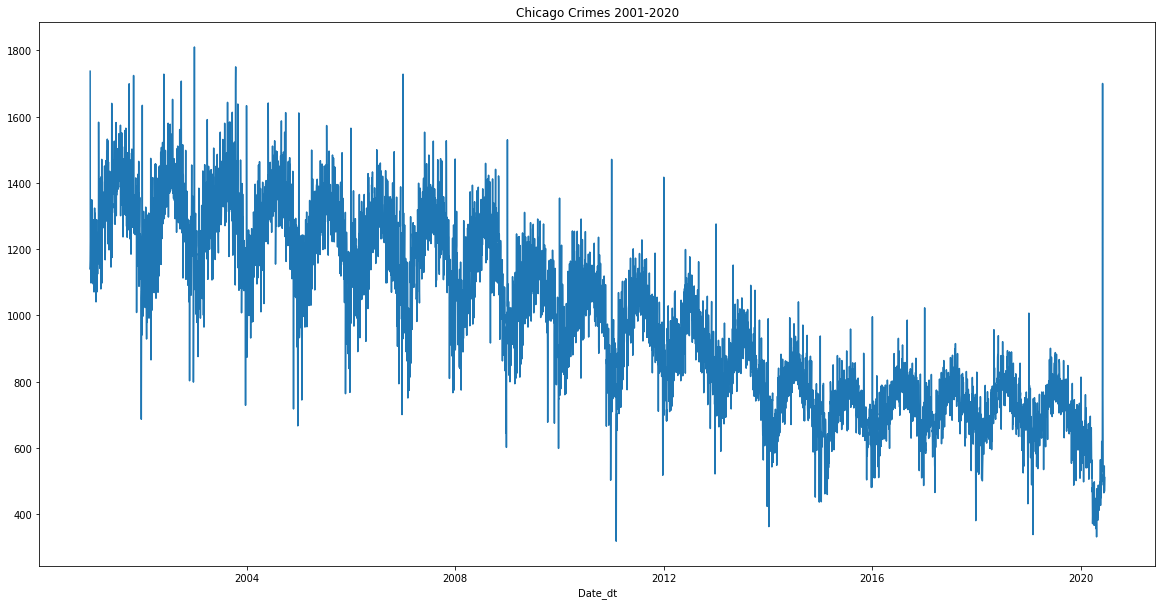

In [8]:
chi_crime.groupby('Date_dt').ID.count().plot.line(figsize=(20,10), title="Chicago Crimes 2001-2020")

In [9]:
chi_crime['Latitude2'] = chi_crime['Latitude'].round(2)
chi_crime['Longitude2'] = chi_crime['Longitude'].round(2)

print ("Valors únics de Latitud i Longitud arrodonint a 2 decimals:")
print (len(chi_crime.Latitude2.unique()), len(chi_crime.Longitude2.unique()))
print("Punts únics amb 2 decimals:\n", str(len(chi_crime.groupby(['Latitude2', 'Longitude2'])['ID'].count())))

Valors únics de Latitud i Longitud arrodonint a 2 decimals:
39 43
Punts únics amb 2 decimals:
 744


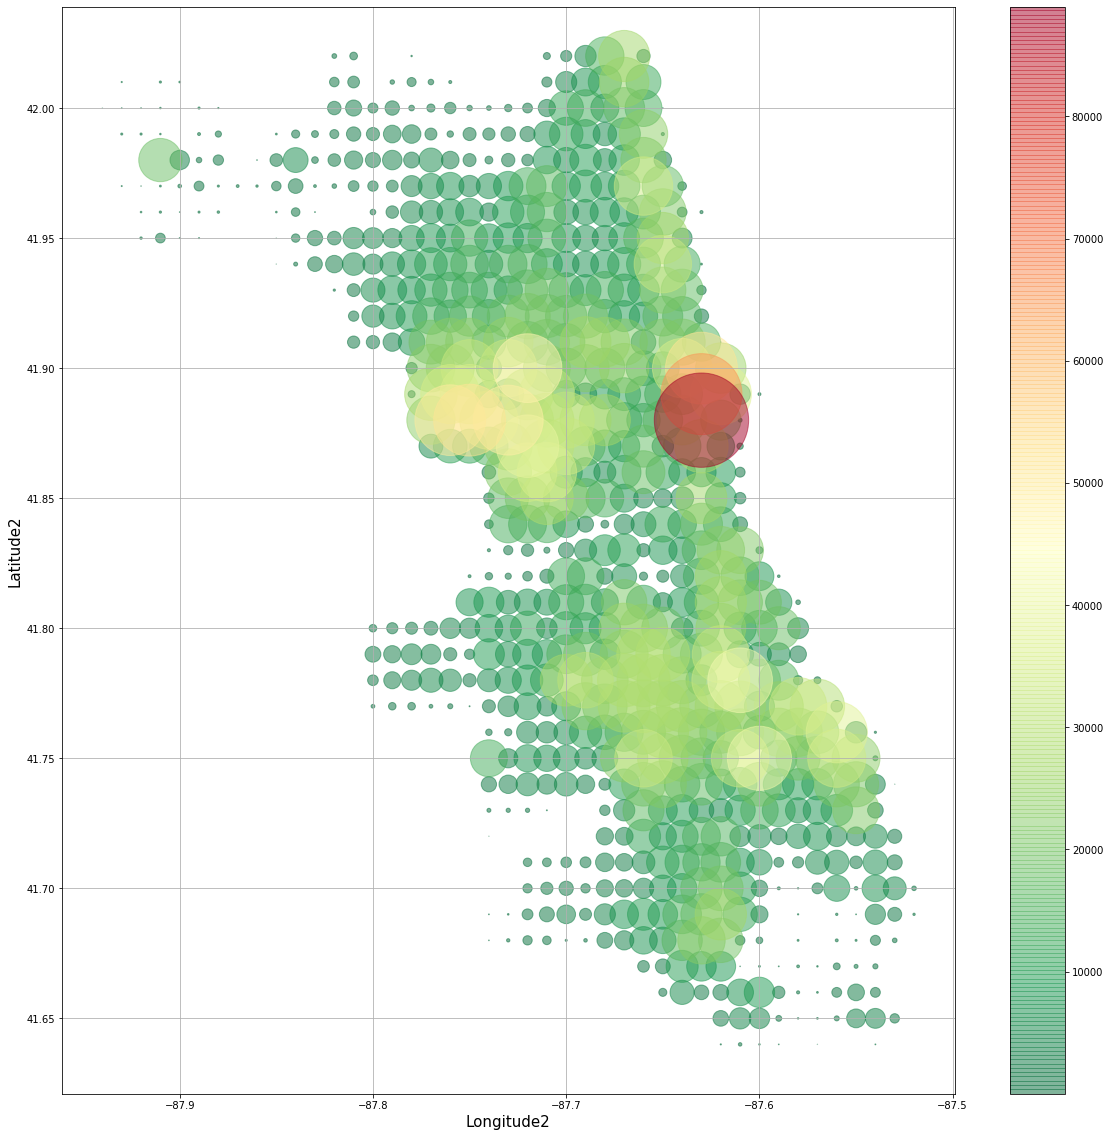

In [10]:
prov_map_lat = chi_crime.groupby(['Latitude2','Longitude2']).ID.count()
prov_map_lat = prov_map_lat.reset_index( )
prov_map_lat = prov_map_lat.sort_values(by=['ID'])

s = [n/10 for n in prov_map_lat.ID] 

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)
cs = ax.scatter(prov_map_lat.Longitude2, prov_map_lat.Latitude2, s = s, c = prov_map_lat.ID, cmap='RdYlGn_r', alpha = 0.5)
ax.set_xlabel('Longitude2', fontsize = 15)
ax.set_ylabel('Latitude2', fontsize = 15)
ax.grid(True)  
cbar = fig.colorbar(cs)
plt.show()

## Selecció de 2 anys       

In [11]:
dataInici = datetime.date(year=2018,month=1,day=1)
dataFi = datetime.date(year=2019,month=12,day=31)
print(len(chi_crime))
chi_crime = chi_crime[(chi_crime['Date_dt']>=dataInici) & (chi_crime['Date_dt']<=dataFi)]
print(len(chi_crime))

7069663
521500


# Primera etapa: Predicció diària per districtes 

In [12]:
chi_district_crime = pd.pivot_table(chi_crime, values='ID', index='Date_dt', columns=['District'], aggfunc='count', fill_value=0)
print (chi_district_crime.shape)

(730, 23)


In [13]:
# split into train and test sets
dataIniciTest = datetime.date(year=2019,month=12,day=1)
dataIniciVal = datetime.date(year=2019,month=10,day=1)

train = chi_district_crime[chi_district_crime.index<dataIniciVal]
validation = chi_district_crime[(chi_district_crime.index>=dataIniciVal) & (chi_district_crime.index<dataIniciTest)]
test = chi_district_crime[chi_district_crime.index>=dataIniciTest]

# normalize the dataset
scaler = MinMaxScaler()
scaler.fit(train)
train_norm = scaler.transform(train)
validation_norm = scaler.transform(validation)
test_norm = scaler.transform(test)

In [14]:
n_input = 7
n_features = len(chi_district_crime.columns)

trainGenerator = TimeseriesGenerator(train_norm, train_norm, length=n_input, batch_size=1)
validGenerator = TimeseriesGenerator(validation_norm, validation_norm, length=n_input)
testGenerator = TimeseriesGenerator(test_norm, test_norm, length=n_input)

In [15]:
import time
n_epochs = 20

start = time.time() 
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(200))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()
mfit = model.fit_generator(trainGenerator, validation_data=validGenerator, epochs=n_epochs)
L_results= ['Chicago', mfit]
print ('Temps execució acumulada {} sec\n'.format(time.time() - start))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 200)            179200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                4623      
Total params: 504,623
Trainable params: 504,623
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
631/631 [==============================] - 15s 24ms/step - loss: 0.0234 - acc: 0.1062 - val_loss: 0.0191 - val_acc: 0.1296
Epoch 2/20
631/631 [==============================] - 16s 25ms/step - loss: 0.0209 - acc: 0.1537 - val_loss: 0.0178 - val_acc: 0.1667
Epoch 3/20
631/631 [==============================] - 14s 22ms/step - loss: 0.0204 - acc: 0.1236 - val_loss: 0.0180 - val_acc: 0.037

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


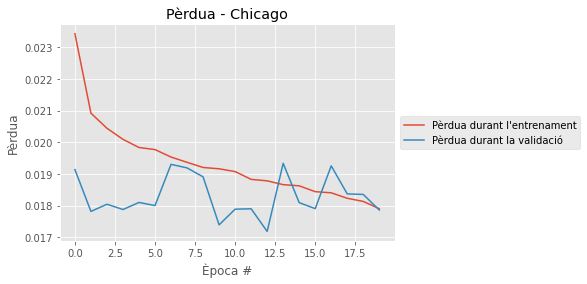

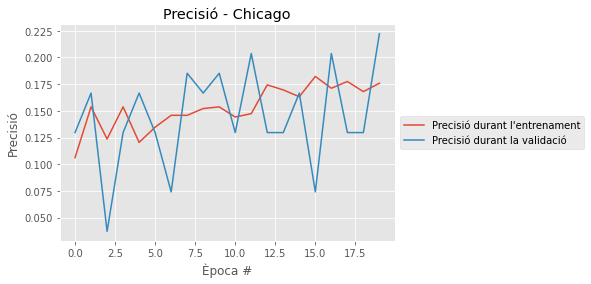

In [16]:
L_results= ['Chicago', mfit]

plt.style.use("ggplot")
plt.figure()

print (L_results[1].history.keys())
plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[2]], label="Pèrdua durant l'entrenament")
plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[0]], label="Pèrdua durant la validació")
plt.title("Pèrdua - "+L_results[0])
plt.xlabel("Època #")
plt.ylabel("Pèrdua")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()
    
plt.figure()

plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[3]], label="Precisió durant l'entrenament")
plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[1]], label="Precisió durant la validació")
plt.title("Precisió - "+L_results[0])
plt.xlabel("Època #")
plt.ylabel("Precisió")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [17]:
predList = []
batch = train_norm[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    predList.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[predList[i]]],axis=1)

In [18]:
predCols = []
for col in chi_district_crime.columns:
    predCols.append('Prediction_'+str(col))
df_predict = pd.DataFrame(scaler.inverse_transform(predList),
                          index=chi_district_crime[-n_input:].index, columns=predCols)

df_test = pd.concat([chi_district_crime,df_predict], axis=1)

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: Ma

rmse:  [12.52996409]


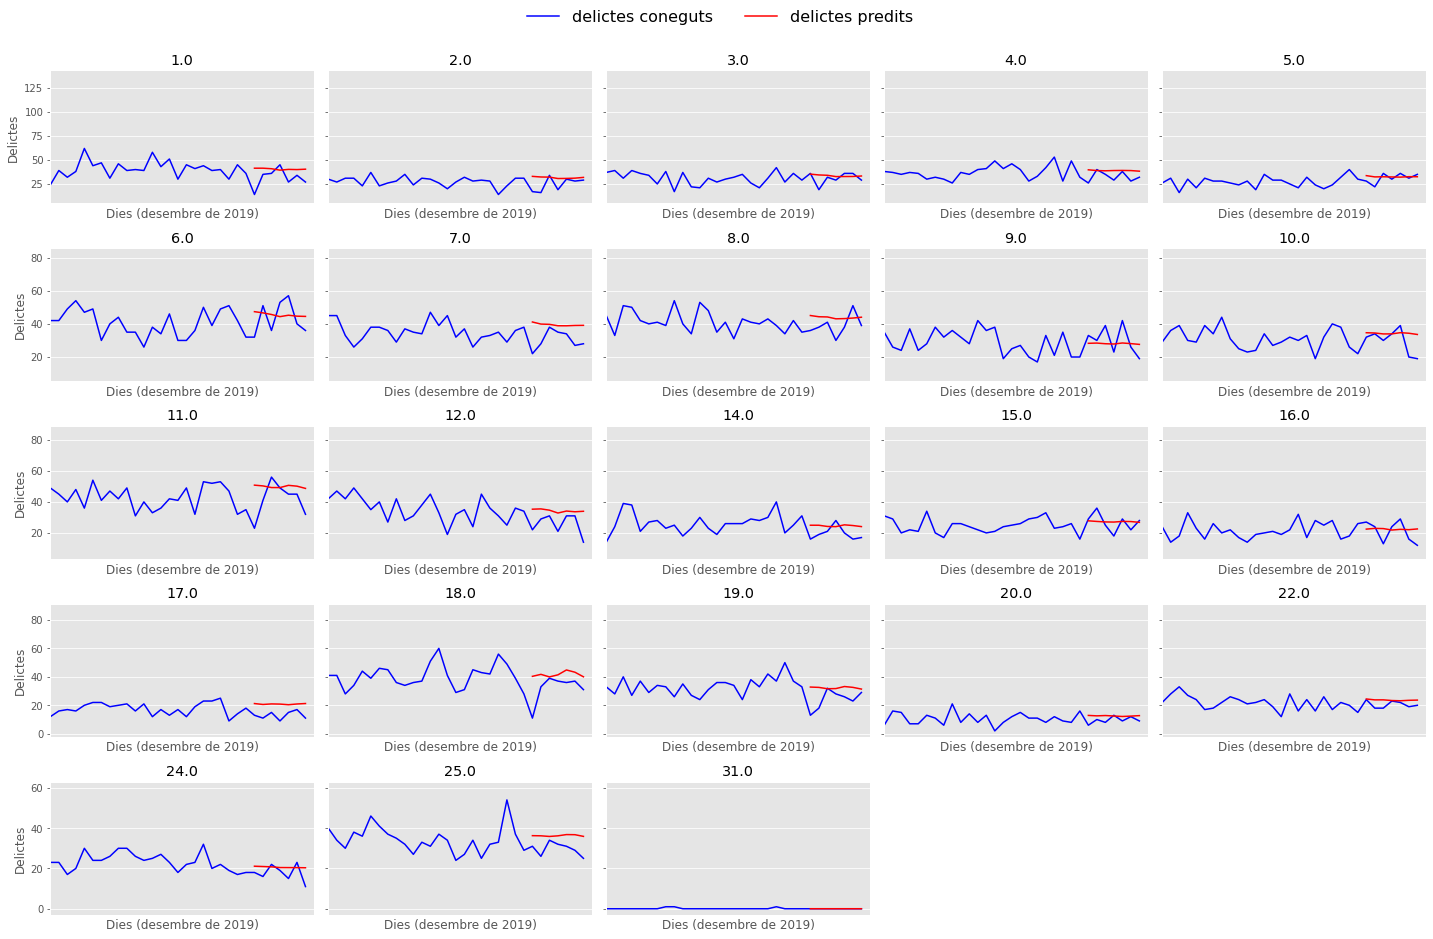

In [19]:
cols = 5 
rows = (len(chi_district_crime.columns)+cols-1)//cols

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, (2.5*rows)),
                        sharex = 'col', sharey='row',
                        subplot_kw={'xticks': []})

axs = axs.flat
for ax in axs[len(chi_district_crime.columns):]: 
    ax.remove()
axs = axs[:len(chi_district_crime.columns)]
i = 0
for col in chi_district_crime.columns:
    axs[i].plot(df_test.index, df_test[col], color ='b', label = 'delictes coneguts')
    axs[i].plot(df_test.index, df_test['Prediction_'+str(col)], color='r', label = "delictes predits")
    axs[i].set_xlim("2019-12-01", "2020-01-01")
    axs[i].set_title(str(col))
    if (i%cols) == 0: 
        axs[i].set_ylabel("Delictes")    
    axs[i].set_xlabel("Dies (desembre de 2019)")    
    i = i+1 

lines, labels = fig.axes[-1]. get_legend_handles_labels()   
plt.figlegend(lines, labels, loc = 'lower center', ncol = 2, fontsize = 16,
              frameon = False, bbox_to_anchor=(0.5, 1) )
plt.tight_layout()

pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

In [20]:
chi_district_crime.mean()

District
1.0     41.509589
2.0     31.220548
3.0     33.384932
4.0     38.321918
5.0     31.678082
6.0     45.287671
7.0     37.982192
8.0     43.484932
9.0     29.834247
10.0    34.110959
11.0    50.846575
12.0    35.453425
14.0    25.104110
15.0    27.261644
16.0    22.915068
17.0    19.449315
18.0    42.267123
19.0    32.342466
20.0    12.552055
22.0    22.578082
24.0    21.173973
25.0    35.601370
31.0     0.023288
dtype: float64